In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             2072 non-null   int64  
 1   name                   2072 non-null   object 
 2   ratio                  2072 non-null   float64
 3   num_matches_2016-2019  2072 non-null   float64
 4   ratio_2016-2019        2072 non-null   float64
 5   num_matches_2020-2021  2072 non-null   float64
 6   ratio_2020-2021        2072 non-null   float64
 7   hand                   2072 non-null   object 
 8   gender                 2072 non-null   object 
 9   ioc                    2072 non-null   object 
 10  birth                  2072 non-null   float64
 11  ht                     2072 non-null   float64
 12  minutes                2072 non-null   float64
 13  perc_ace               2072 non-null   float64
 14  serv_won_tot_seve      2072 non-null   float64
 15  bpFa

In [3]:
del df['Unnamed: 0']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2072 non-null   object 
 1   ratio                  2072 non-null   float64
 2   num_matches_2016-2019  2072 non-null   float64
 3   ratio_2016-2019        2072 non-null   float64
 4   num_matches_2020-2021  2072 non-null   float64
 5   ratio_2020-2021        2072 non-null   float64
 6   hand                   2072 non-null   object 
 7   gender                 2072 non-null   object 
 8   ioc                    2072 non-null   object 
 9   birth                  2072 non-null   float64
 10  ht                     2072 non-null   float64
 11  minutes                2072 non-null   float64
 12  perc_ace               2072 non-null   float64
 13  serv_won_tot_seve      2072 non-null   float64
 14  bpFaced                2072 non-null   float64
 15  perc

### Drop categorical data

In [5]:
del df['name']
del df['hand']
del df['gender']
del df['ioc']

In [6]:
df.head()

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
0,0.181818,10.0,0.200000,1.0,0.000000,1996.0,187.076923,86.694444,14.98,0.587855,83.0,12.32,47.78,8.82,5.88,75.79
1,0.477707,142.0,0.478873,15.0,0.466667,1994.0,170.857143,61.621951,1.30,0.279256,819.0,4.67,22.10,3.18,5.39,39.67
2,0.500000,13.0,0.461538,3.0,0.666667,1998.0,183.800000,86.875000,20.59,0.613701,111.0,10.89,51.65,7.12,10.10,70.86
3,0.588710,111.0,0.576577,13.0,0.692308,1992.0,172.137193,62.577626,3.37,0.591260,1055.0,11.18,54.40,3.83,7.73,52.62
4,0.153846,13.0,0.153846,0.0,0.000000,1995.0,172.137193,59.409091,0.00,0.189542,110.0,16.30,17.20,0.51,2.55,11.88


### Drop most correlated attributes

In [7]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr = df[df.columns[i]].corr(df[df.columns[j]])
        if  corr > corr_threshold:
            print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
num_matches_2016-2019	bpFaced	0.9253
serv_won_tot_seve	perc_2ndwon	0.9248


In [8]:
del df['num_matches_2016-2019'] #PERCHE'?
del df['bpFaced']
del df['serv_won_tot_seve']
del df['perc_2ndwon']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ratio                  2072 non-null   float64
 1   ratio_2016-2019        2072 non-null   float64
 2   num_matches_2020-2021  2072 non-null   float64
 3   ratio_2020-2021        2072 non-null   float64
 4   birth                  2072 non-null   float64
 5   ht                     2072 non-null   float64
 6   minutes                2072 non-null   float64
 7   perc_ace               2072 non-null   float64
 8   perc_df                2072 non-null   float64
 9   perc_v_ace             2072 non-null   float64
 10  perc_v_df              2072 non-null   float64
 11  perc_v_1stwon          2072 non-null   float64
dtypes: float64(12)
memory usage: 194.4 KB


### MinMax Normalization before clustering

In [10]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
df_norm_minmax = minmax_scaler.fit_transform(df.values)
print(df_norm_minmax)

[[0.06811316 0.2        0.00990099 ... 0.37650602 0.32867524 0.93740611]
 [0.48378779 0.47887324 0.14851485 ... 0.133821   0.30128563 0.48522784]
 [0.51510574 0.46153846 0.02970297 ... 0.30335628 0.56456121 0.87568853]
 ...
 [0.44116712 0.38596491 0.18811881 ... 0.07917384 0.22079374 0.34088633]
 [0.57580844 0.53846154 0.02970297 ... 0.36660929 0.41475685 0.82511267]
 [0.54257456 0.54658385 0.17821782 ... 0.09380379 0.28731135 0.44416625]]


### ZScore Normalization before clustering

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.head().values)

StandardScaler()

In [12]:
df.head().values

array([[1.81818182e-01, 2.00000000e-01, 1.00000000e+00, 0.00000000e+00,
        1.99600000e+03, 1.87076923e+02, 8.66944444e+01, 1.49800000e+01,
        1.23200000e+01, 8.82000000e+00, 5.88000000e+00, 7.57900000e+01],
       [4.77707006e-01, 4.78873239e-01, 1.50000000e+01, 4.66666667e-01,
        1.99400000e+03, 1.70857143e+02, 6.16219512e+01, 1.30000000e+00,
        4.67000000e+00, 3.18000000e+00, 5.39000000e+00, 3.96700000e+01],
       [5.00000000e-01, 4.61538462e-01, 3.00000000e+00, 6.66666667e-01,
        1.99800000e+03, 1.83800000e+02, 8.68750000e+01, 2.05900000e+01,
        1.08900000e+01, 7.12000000e+00, 1.01000000e+01, 7.08600000e+01],
       [5.88709677e-01, 5.76576577e-01, 1.30000000e+01, 6.92307692e-01,
        1.99200000e+03, 1.72137193e+02, 6.25776256e+01, 3.37000000e+00,
        1.11800000e+01, 3.83000000e+00, 7.73000000e+00, 5.26200000e+01],
       [1.53846154e-01, 1.53846154e-01, 0.00000000e+00, 0.00000000e+00,
        1.99500000e+03, 1.72137193e+02, 5.94090909e+01, 0.00

In [13]:
scaler.transform(df.head().values)

array([[-1.11745892, -1.04668573, -0.85552774, -1.18473318,  0.5       ,
         1.4478336 ,  1.2134539 ,  0.84368133,  0.33373308,  1.40026557,
        -0.17914955,  1.10960293],
       [ 0.5474298 ,  0.62925076,  1.36250714,  0.32946232, -0.5       ,
        -0.93019065, -0.78042968, -0.82128702, -1.7119865 , -0.51288797,
        -0.37422351, -0.45438902],
       [ 0.67286662,  0.52507445, -0.53866561,  0.97840324,  1.5       ,
         0.96739537,  1.22781253,  1.5264644 , -0.04866941,  0.82360581,
         1.50087515,  0.89613448],
       [ 1.17201268,  1.2164157 ,  1.04564501,  1.0616008 , -1.5       ,
        -0.74251916, -0.70442992, -0.56935102,  0.02888075, -0.29240042,
         0.55735417,  0.10634452],
       [-1.27485018, -1.32405518, -1.0139588 , -1.18473318,  0.        ,
        -0.74251916, -0.95640683, -0.97950769,  1.39804208, -1.418583  ,
        -1.50485625, -1.65769291]])

In [14]:
scaler.inverse_transform(scaler.transform(df.head().values))

array([[1.81818182e-01, 2.00000000e-01, 1.00000000e+00, 0.00000000e+00,
        1.99600000e+03, 1.87076923e+02, 8.66944444e+01, 1.49800000e+01,
        1.23200000e+01, 8.82000000e+00, 5.88000000e+00, 7.57900000e+01],
       [4.77707006e-01, 4.78873239e-01, 1.50000000e+01, 4.66666667e-01,
        1.99400000e+03, 1.70857143e+02, 6.16219512e+01, 1.30000000e+00,
        4.67000000e+00, 3.18000000e+00, 5.39000000e+00, 3.96700000e+01],
       [5.00000000e-01, 4.61538462e-01, 3.00000000e+00, 6.66666667e-01,
        1.99800000e+03, 1.83800000e+02, 8.68750000e+01, 2.05900000e+01,
        1.08900000e+01, 7.12000000e+00, 1.01000000e+01, 7.08600000e+01],
       [5.88709677e-01, 5.76576577e-01, 1.30000000e+01, 6.92307692e-01,
        1.99200000e+03, 1.72137193e+02, 6.25776256e+01, 3.37000000e+00,
        1.11800000e+01, 3.83000000e+00, 7.73000000e+00, 5.26200000e+01],
       [1.53846154e-01, 1.53846154e-01, 0.00000000e+00, 0.00000000e+00,
        1.99500000e+03, 1.72137193e+02, 5.94090909e+01, 0.00

### Partitional and center-based clustering: K-Means

**Objective:** Clusters the data into $k$ groups.
* **Init step:** Select k points at random as cluster centers.
* **Assignment step:** Assign each instance to the cluster with the closest mean according to the distance function.
* **Update step**: Calculate the new means to be the centroids of the instances in the new clusters.
* ***Repeat*** steps 2 and 3 until the assignment no longer change.

There is no guarantee that the optimum is found using this algorithm.

> Tan, P. N. (2006). Introduction to data mining. Pearson Education India.

## Problems

* Initial Centroids
* Number of clusters

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Parameters:
* **n_clusters** (default 8): The number of clusters
* **n_init** (default 10): Number of time k-means will be run with different initial centroids. The final results will be the best output in terms of inertia.
* **max_iter** (default 300): Maximum number of iterations of the k-means algorithm for a single run.

In [16]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100)

X = scaler.fit_transform(df.values) 
print(kmeans.fit(X))

"""
Output:
* **labels_**: Labels of each point
* **cluster\_centers_**: Coordinates of cluster centers
* **inertia_**: Sum of squared distances of samples to their closest cluster center.
"""
print( kmeans.labels_[:5] ) #labels
print( np.unique(kmeans.labels_, return_counts=True) ) # observing the size of each cluster
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print( dict(zip(bins, hist)) )

KMeans(max_iter=100, n_clusters=3)
[1 2 0 2 2]
(array([0, 1, 2], dtype=int32), array([569, 716, 787]))
{0: 569, 1: 716, 2: 787}


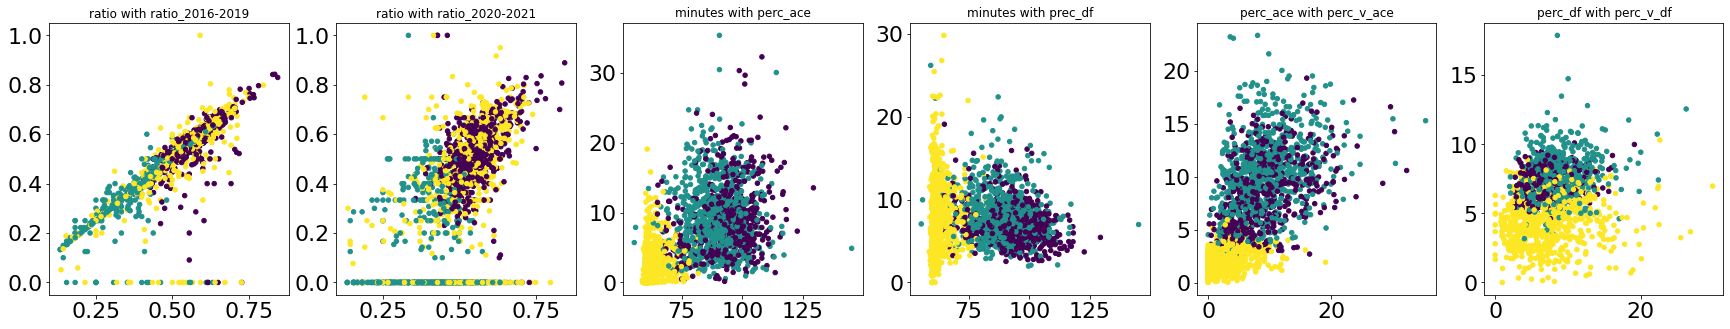

In [17]:
#Visualization of the clusters in 2 dimensions

f, axs = plt.subplots(ncols=6, figsize=(30,5))

axs[0].scatter(df['ratio'], df['ratio_2016-2019'], c=kmeans.labels_, s=20)
axs[0].tick_params(axis='both', which='major', labelsize=22)
axs[0].set_title("ratio with ratio_2016-2019")

axs[1].scatter(df['ratio'], df['ratio_2020-2021'], c=kmeans.labels_, s=20)
axs[1].tick_params(axis='both', which='major', labelsize=22)
axs[1].set_title("ratio with ratio_2020-2021")

axs[2].scatter(df['minutes'], df['perc_ace'], c=kmeans.labels_, s=20)
axs[2].tick_params(axis='both', which='major', labelsize=22)
axs[2].set_title("minutes with perc_ace")

axs[3].scatter(df['minutes'], df['perc_df'], c=kmeans.labels_, s=20)
axs[3].tick_params(axis='both', which='major', labelsize=22)
axs[3].set_title("minutes with prec_df")

axs[4].scatter(df['perc_ace'], df['perc_v_ace'], c=kmeans.labels_, s=20)
axs[4].tick_params(axis='both', which='major', labelsize=22)
axs[4].set_title("perc_ace with perc_v_ace")

axs[5].scatter(df['perc_df'], df['perc_v_df'], c=kmeans.labels_, s=20)
axs[5].tick_params(axis='both', which='major', labelsize=22)
axs[5].set_title("perc_df with perc_v_df")

    
plt.show()

In [18]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100)

X = minmax_scaler.fit_transform(df.values) 
print(kmeans.fit(X))
print(kmeans.labels_[:5])
print(np.unique(kmeans.labels_, return_counts=True))
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print( dict(zip(bins, hist)) )

KMeans(max_iter=100, n_clusters=3)
[2 1 0 1 1]
(array([0, 1, 2], dtype=int32), array([585, 772, 715]))
{0: 585, 1: 772, 2: 715}


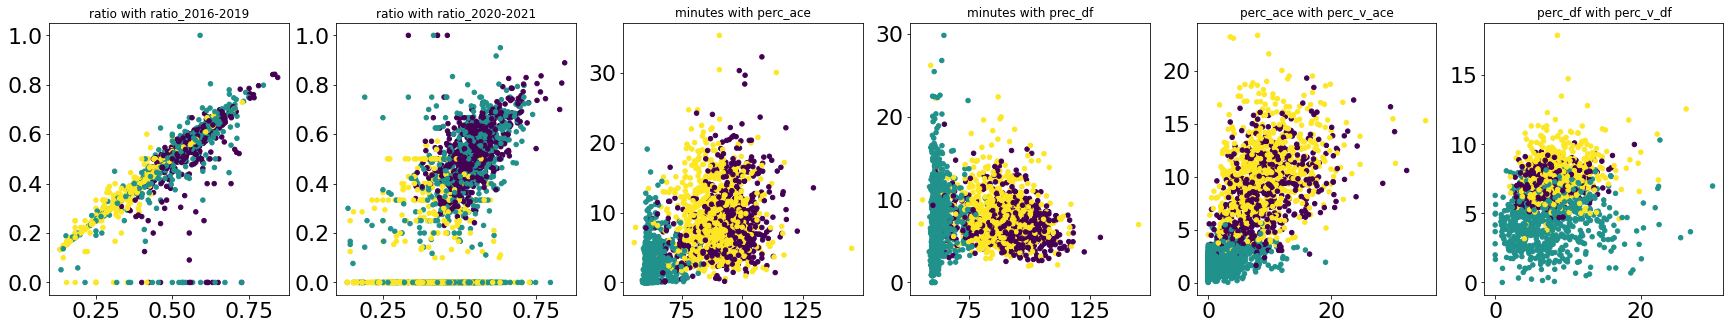

In [19]:
#Visualization of the clusters in 2 dimensions

f, axs = plt.subplots(ncols=6, figsize=(30,5))

axs[0].scatter(df['ratio'], df['ratio_2016-2019'], c=kmeans.labels_, s=20)
axs[0].tick_params(axis='both', which='major', labelsize=22)
axs[0].set_title("ratio with ratio_2016-2019")

axs[1].scatter(df['ratio'], df['ratio_2020-2021'], c=kmeans.labels_, s=20)
axs[1].tick_params(axis='both', which='major', labelsize=22)
axs[1].set_title("ratio with ratio_2020-2021")

axs[2].scatter(df['minutes'], df['perc_ace'], c=kmeans.labels_, s=20)
axs[2].tick_params(axis='both', which='major', labelsize=22)
axs[2].set_title("minutes with perc_ace")

axs[3].scatter(df['minutes'], df['perc_df'], c=kmeans.labels_, s=20)
axs[3].tick_params(axis='both', which='major', labelsize=22)
axs[3].set_title("minutes with prec_df")

axs[4].scatter(df['perc_ace'], df['perc_v_ace'], c=kmeans.labels_, s=20)
axs[4].tick_params(axis='both', which='major', labelsize=22)
axs[4].set_title("perc_ace with perc_v_ace")

axs[5].scatter(df['perc_df'], df['perc_v_df'], c=kmeans.labels_, s=20)
axs[5].tick_params(axis='both', which='major', labelsize=22)
axs[5].set_title("perc_df with perc_v_df")

    
plt.show()

### Elbow Method on the clusters Inertia
In cluster analysis, the elbow method is a heuristic used in determining the optimal number of clusters in a data set. 
<br>It consists of plotting the SSE as a function of the number of clusters, and **picking the elbow** of the curve as the *k* to use.

We start from an initial value of 2 and we keep computing the clusterization until we reach the value of 30, our choice for the maximum value of *k*. 
<br>Considering ranges of k differing in size may lead to slightly different elbows, so we also plot the curves of the intervals [2,10] and [2,20].

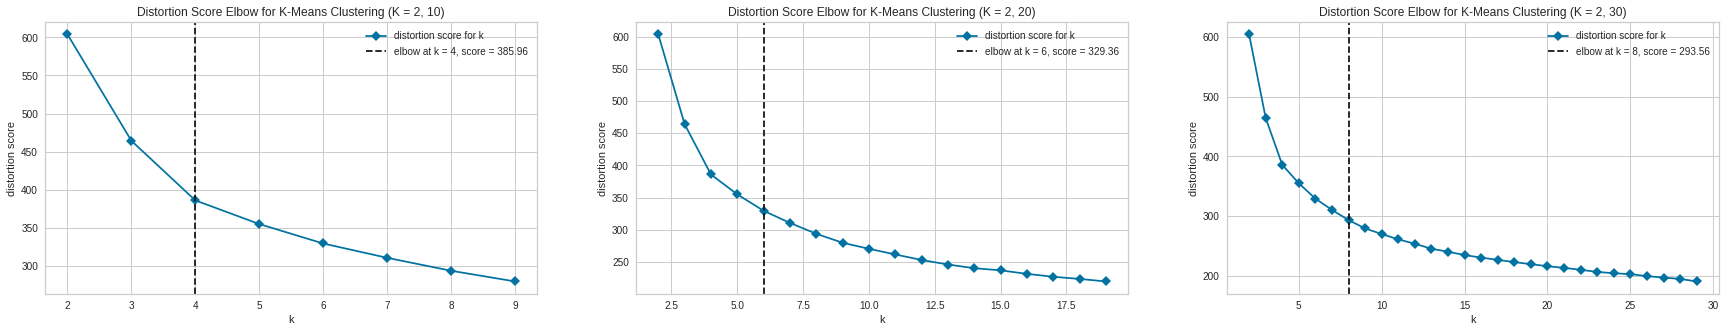

In [22]:
from yellowbrick.cluster import KElbowVisualizer

k_start = [2]
k_max = [10, 20, 30]
Ks = []
model = KMeans()

# print the elbow plots
f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))

for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='distortion', timings=False, ax=axs[i])
    vis.fit(X)  
    axs[i].set_title('Distortion Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('distortion score')
    axs[i].set_xlabel('k')
    axs[i].legend(['distortion score for k','elbow at k = ' + str(vis.elbow_value_) + ', score = ' + '{:.2f}'.format(vis.elbow_score_)])
    if (vis.elbow_value_ not in Ks) and (vis.elbow_value_ != None):
        Ks.append(vis.elbow_value_)
plt.show()

### Average Silhouette Method
The silhouette score is a indicator of both separation and cohesion among clusters. Here we look for the clusterization with the highest average silhouette score among those computed by K-means.

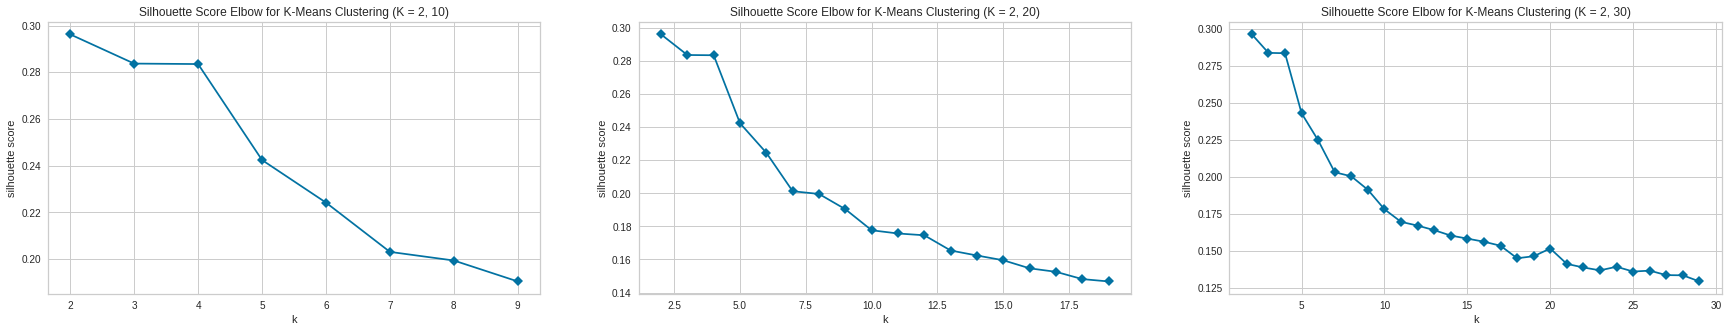

In [23]:
k_start = [2]
k_max = [10, 20, 30]
model = KMeans()

# print the elbow plots
f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))

for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='silhouette', timings=False, ax=axs[i], locate_elbow=False)
    vis.fit(X)  
    axs[i].set_title('Silhouette Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('silhouette score')
    axs[i].set_xlabel('k')
plt.show()

An analysis of the average Silhouette score highlights a global maxima for k equals to 2 and a local maxima for k equals to 3 or 4.

In [25]:
k_from_sil = [2,3,4]

We add these values to the list of candidates for the optimal value of k. 

In [26]:
for k in k_from_sil:
    if k not in Ks:
        Ks = np.append(Ks, k_from_sil)